In [1]:
%reset
%load_ext autoreload
%autoreload 2

import sys

sys.path.append("../")
import torch
import numpy as np
import defmod as dm
import multimodule_usefulfunctions as mm 
import matplotlib.pyplot as plt
import defmod.hamiltonian_multishape as hamiltonian
import model_graddesc as model

torch.set_default_tensor_type(torch.DoubleTensor)

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
nb_pts1 = 10
nb_pts2 = 7
dim = 2

o1 = torch.tensor([0.,0.])
o2 = torch.tensor([10.,0.])
origin = [o1,o2]
r1 = 1.
r2 = 2.
radius = [r1, r2]
nb_pts = [nb_pts1, nb_pts2]
source = mm.multipleCircles(origin, radius, nb_pts)

origin_target = [[0,5], [10,-5]]
target = mm.multipleCircles(origin, [2., 1.], nb_pts)

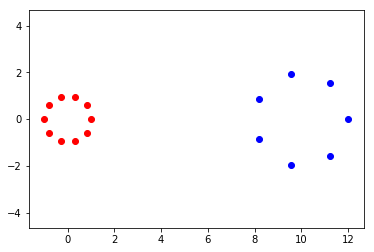

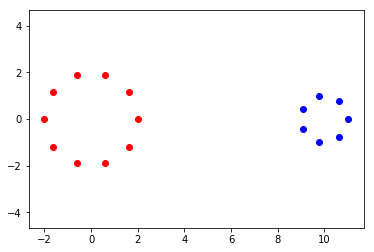

In [3]:
plt.figure()
plt.scatter(source[0][:, 0].detach().numpy(), source[0][:, 1].detach().numpy(), c='red')
plt.scatter(source[1][:, 0].detach().numpy(), source[1][:, 1].detach().numpy(), c='blue')
plt.axis('equal')

plt.figure()
plt.scatter(target[0][:, 0].detach().numpy(), target[0][:, 1].detach().numpy(), c='red')
plt.scatter(target[1][:, 0].detach().numpy(), target[1][:, 1].detach().numpy(), c='blue')

plt.axis('equal')
plt.show()

In [4]:
# Defining the deformation modules
sigma1 = 2
manifold1 = dm.manifold.Landmarks(dim, nb_pts1, gd=source[0].view(-1))
#trans1 = dm.deformationmodules.Translations(manifold1, sigma1)
#man_local1 = dm.manifold.Landmarks(2,1)
#scal1 = dm.deformationmodules.LocalScaling(man_local1, sigma1)

sigma2 = 2
s#trans2 = dm.deformationmodules.Translations(manifold2, sigma2)
#man_local2 = dm.manifold.Landmarks(2,1)
#scal2 = dm.deformationmodules.LocalScaling(man_local2, sigma2)

#module_list = [scal1, scal2]
#sigma_bg = 0.1
#modules = dm.multishape.MultiShapeModule(module_list, sigma_bg)

In [5]:
scal1 = dm.deformationmodules.GlobalScaling(manifold1, sigma1)
scal2 = dm.deformationmodules.GlobalScaling(manifold2, sigma2)
silent1 = dm.deformationmodules.SilentPoints(manifold1)
silent2 = dm.deformationmodules.SilentPoints(manifold2)

compound1 = dm.deformationmodules.CompoundModule([silent1, scal1])
compound2 = dm.deformationmodules.CompoundModule([silent2, scal2])


module_list = [compound1, compound2]
sigma_bg = 0.1
modules = dm.multishape.MultiShapeModule(module_list, sigma_bg)

In [12]:
constr_Id = dm.constraints.Identity_Silent()
H = hamiltonian.Hamiltonian_multi(modules, constr_Id)

In [13]:
#gd0_list = [mm.computeCenter(source[0]), mm.computeCenter(source[1]), [mm.computeCenter(source[0]), mm.computeCenter(source[1])]]
#mom0_list = [torch.zeros(dim), torch.zeros(dim), [torch.zeros(dim), torch.zeros(dim)]]

In [14]:
#gd0_list = [*source, source]
#mom0_list = [*[torch.zeros(gd.shape) for gd in modules.manifold.gd[:-1]], [torch.zeros(gd.shape) for gd in modules.manifold.gd[-1]]]

In [19]:
# set parameters
reg_param = 10**-2 # regularisation parameter

#gd0_tensor = torch.cat([gd0_list[0], gd0_list[1], gd0_list[2][0], gd0_list[2][1]],0).requires_grad_().view(-1)
#mom0_tensor = torch.cat([mom0_list[0], mom0_list[1], mom0_list[2][0], mom0_list[2][1]],0).requires_grad_().view(-1)

gd0_tensor = torch.cat(modules.manifold.unroll_gd().copy(),0).requires_grad_().view(-1)
mom0_tensor = torch.cat(modules.manifold.unroll_cotan().copy(),0).requires_grad_().view(-1)

gd0_tensor.retain_grad()
mom0_tensor.retain_grad()
    
EnergyFunctional = model.EnergyFunctional(modules, H, constr_Id, source, target, dim, reg_param)

# do registration
X = [gd0_tensor, mom0_tensor]
X = model.gradientdescent(EnergyFunctional, X)

energy: constraints_________________
tensor([[ 1.4629e-01,  1.7993e-16],
        [ 1.1620e-01,  6.4566e-02],
        [ 2.9247e-02,  1.2295e-01],
        [-5.3554e-02,  1.3434e-01],
        [-1.0325e-01,  9.4300e-02],
        [-1.2360e-01,  1.5423e-16],
        [-1.0325e-01, -9.4300e-02],
        [-5.3554e-02, -1.3434e-01],
        [ 2.9247e-02, -1.2295e-01],
        [ 1.1620e-01, -6.4566e-02],
        [ 6.8097e-02,  3.0404e-17],
        [ 4.0100e-02,  4.2187e-02],
        [-2.2370e-02,  6.3007e-02],
        [-5.1356e-02,  3.6447e-02],
        [-5.1356e-02, -3.6447e-02],
        [-2.2370e-02, -6.3007e-02],
        [ 4.0100e-02, -4.2187e-02]], grad_fn=<CatBackward>)
cost: 0.0217964527203 attach: 11.155704518828072
 iter : 0  ,total energy: 11.177500971548334
energy: constraints_________________
tensor([[ 1.4629e-01,  1.7993e-16],
        [ 1.1620e-01,  6.4566e-02],
        [ 2.9247e-02,  1.2295e-01],
        [-5.3554e-02,  1.3434e-01],
        [-1.0325e-01,  9.4300e-02],
        [-1.2360

cost: 0.0217939479904 attach: 11.155704518828072
energy: constraints_________________
tensor([[ 1.4657e-01,  1.8027e-16],
        [ 1.1642e-01,  6.4687e-02],
        [ 2.9302e-02,  1.2318e-01],
        [-5.3655e-02,  1.3459e-01],
        [-1.0345e-01,  9.4477e-02],
        [-1.2383e-01,  1.5452e-16],
        [-1.0345e-01, -9.4477e-02],
        [-5.3655e-02, -1.3459e-01],
        [ 2.9302e-02, -1.2318e-01],
        [ 1.1642e-01, -6.4687e-02],
        [ 6.8156e-02,  3.0431e-17],
        [ 4.0135e-02,  4.2224e-02],
        [-2.2389e-02,  6.3062e-02],
        [-5.1401e-02,  3.6478e-02],
        [-5.1401e-02, -3.6478e-02],
        [-2.2389e-02, -6.3062e-02],
        [ 4.0135e-02, -4.2224e-02]], grad_fn=<CatBackward>)
cost: 0.0217931114399 attach: 11.155704518828072
c 0
 iter : 5  ,total energy: 11.177497630267938
energy: constraints_________________
tensor([[ 1.4657e-01,  1.8027e-16],
        [ 1.1642e-01,  6.4687e-02],
        [ 2.9302e-02,  1.2318e-01],
        [-5.3655e-02,  1.3459e-01],

cost: 0.0217856628392 attach: 11.155704518828072
energy: constraints_________________
tensor([[ 1.4739e-01,  1.8127e-16],
        [ 1.1707e-01,  6.5047e-02],
        [ 2.9465e-02,  1.2387e-01],
        [-5.3953e-02,  1.3534e-01],
        [-1.0402e-01,  9.5003e-02],
        [-1.2452e-01,  1.5538e-16],
        [-1.0402e-01, -9.5003e-02],
        [-5.3953e-02, -1.3534e-01],
        [ 2.9465e-02, -1.2387e-01],
        [ 1.1707e-01, -6.5047e-02],
        [ 6.8332e-02,  3.0509e-17],
        [ 4.0238e-02,  4.2333e-02],
        [-2.2447e-02,  6.3225e-02],
        [-5.1534e-02,  3.6573e-02],
        [-5.1534e-02, -3.6573e-02],
        [-2.2447e-02, -6.3225e-02],
        [ 4.0238e-02, -4.2333e-02]], grad_fn=<CatBackward>)
cost: 0.0217831808747 attach: 11.155704518828072
c 0
 iter : 11  ,total energy: 11.177487699702747
energy: constraints_________________
tensor([[ 1.4739e-01,  1.8127e-16],
        [ 1.1707e-01,  6.5047e-02],
        [ 2.9465e-02,  1.2387e-01],
        [-5.3953e-02,  1.3534e-01]

cost: 0.021761208894 attach: 11.155704518828072
energy: constraints_________________
tensor([[ 1.4980e-01,  1.8425e-16],
        [ 1.1899e-01,  6.6115e-02],
        [ 2.9949e-02,  1.2590e-01],
        [-5.4839e-02,  1.3757e-01],
        [-1.0573e-01,  9.6563e-02],
        [-1.2656e-01,  1.5793e-16],
        [-1.0573e-01, -9.6563e-02],
        [-5.4839e-02, -1.3757e-01],
        [ 2.9949e-02, -1.2590e-01],
        [ 1.1899e-01, -6.6115e-02],
        [ 6.8857e-02,  3.0744e-17],
        [ 4.0547e-02,  4.2658e-02],
        [-2.2619e-02,  6.3711e-02],
        [-5.1930e-02,  3.6854e-02],
        [-5.1930e-02, -3.6854e-02],
        [-2.2619e-02, -6.3711e-02],
        [ 4.0547e-02, -4.2658e-02]], grad_fn=<CatBackward>)
cost: 0.0217539382698 attach: 11.155704518828072
c 0
 iter : 17  ,total energy: 11.177458457097893
energy: constraints_________________
tensor([[ 1.4980e-01,  1.8425e-16],
        [ 1.1899e-01,  6.6115e-02],
        [ 2.9949e-02,  1.2590e-01],
        [-5.4839e-02,  1.3757e-01],

cost: 0.0216906706729 attach: 11.155704518828072
energy: constraints_________________
tensor([[ 1.5688e-01,  1.9295e-16],
        [ 1.2461e-01,  6.9236e-02],
        [ 3.1363e-02,  1.3184e-01],
        [-5.7428e-02,  1.4406e-01],
        [-1.1072e-01,  1.0112e-01],
        [-1.3254e-01,  1.6538e-16],
        [-1.1072e-01, -1.0112e-01],
        [-5.7428e-02, -1.4406e-01],
        [ 3.1363e-02, -1.3184e-01],
        [ 1.2461e-01, -6.9236e-02],
        [ 7.0419e-02,  3.1441e-17],
        [ 4.1468e-02,  4.3626e-02],
        [-2.3133e-02,  6.5156e-02],
        [-5.3108e-02,  3.7690e-02],
        [-5.3108e-02, -3.7690e-02],
        [-2.3133e-02, -6.5156e-02],
        [ 4.1468e-02, -4.3626e-02]], grad_fn=<CatBackward>)
cost: 0.0216701657134 attach: 11.155704518828072
c 0
 iter : 23  ,total energy: 11.177374684541496
energy: constraints_________________
tensor([[ 1.5688e-01,  1.9295e-16],
        [ 1.2461e-01,  6.9236e-02],
        [ 3.1363e-02,  1.3184e-01],
        [-5.7428e-02,  1.4406e-01]

cost: 0.0215005619177 attach: 11.155704518828072
energy: constraints_________________
tensor([[ 1.7669e-01,  2.1732e-16],
        [ 1.4035e-01,  7.7981e-02],
        [ 3.5324e-02,  1.4850e-01],
        [-6.4682e-02,  1.6226e-01],
        [-1.2471e-01,  1.1389e-01],
        [-1.4928e-01,  1.8627e-16],
        [-1.2471e-01, -1.1389e-01],
        [-6.4682e-02, -1.6226e-01],
        [ 3.5324e-02, -1.4850e-01],
        [ 1.4035e-01, -7.7981e-02],
        [ 7.5035e-02,  3.3502e-17],
        [ 4.4185e-02,  4.6486e-02],
        [-2.4649e-02,  6.9427e-02],
        [-5.6589e-02,  4.0160e-02],
        [-5.6589e-02, -4.0160e-02],
        [-2.4649e-02, -6.9427e-02],
        [ 4.4185e-02, -4.6486e-02]], grad_fn=<CatBackward>)
cost: 0.0214489100718 attach: 11.155704518828072
c 0
 iter : 29  ,total energy: 11.177153428899912
energy: constraints_________________
tensor([[ 1.7669e-01,  2.1732e-16],
        [ 1.4035e-01,  7.7981e-02],
        [ 3.5324e-02,  1.4850e-01],
        [-6.4682e-02,  1.6226e-01]

cost: 0.0210796101101 attach: 11.155704518828072
energy: constraints_________________
tensor([[ 2.2558e-01,  2.7745e-16],
        [ 1.7918e-01,  9.9558e-02],
        [ 4.5098e-02,  1.8958e-01],
        [-8.2579e-02,  2.0715e-01],
        [-1.5921e-01,  1.4541e-01],
        [-1.9058e-01,  2.3781e-16],
        [-1.5921e-01, -1.4541e-01],
        [-8.2579e-02, -2.0715e-01],
        [ 4.5098e-02, -1.8958e-01],
        [ 1.7918e-01, -9.9558e-02],
        [ 8.8379e-02,  3.9460e-17],
        [ 5.2043e-02,  5.4752e-02],
        [-2.9032e-02,  8.1773e-02],
        [-6.6652e-02,  4.7302e-02],
        [-6.6652e-02, -4.7302e-02],
        [-2.9032e-02, -8.1773e-02],
        [ 5.2043e-02, -5.4752e-02]], grad_fn=<CatBackward>)
cost: 0.020986171238 attach: 11.155704518828072
c 0
 iter : 35  ,total energy: 11.176690690066078
energy: constraints_________________
tensor([[ 2.2558e-01,  2.7745e-16],
        [ 1.7918e-01,  9.9558e-02],
        [ 4.5098e-02,  1.8958e-01],
        [-8.2579e-02,  2.0715e-01],

cost: 0.0205239931983 attach: 11.155704518828072
energy: constraints_________________
tensor([[ 3.0797e-01,  3.7878e-16],
        [ 2.4463e-01,  1.3592e-01],
        [ 6.1570e-02,  2.5883e-01],
        [-1.1274e-01,  2.8281e-01],
        [-2.1736e-01,  1.9852e-01],
        [-2.6019e-01,  3.2467e-16],
        [-2.1736e-01, -1.9852e-01],
        [-1.1274e-01, -2.8281e-01],
        [ 6.1570e-02, -2.5883e-01],
        [ 2.4463e-01, -1.3592e-01],
        [ 1.2456e-01,  5.5615e-17],
        [ 7.3349e-02,  7.7168e-02],
        [-4.0918e-02,  1.1525e-01],
        [-9.3939e-02,  6.6667e-02],
        [-9.3939e-02, -6.6667e-02],
        [-4.0918e-02, -1.1525e-01],
        [ 7.3349e-02, -7.7168e-02]], grad_fn=<CatBackward>)
cost: 0.0204506243226 attach: 11.155704518828072
c 0
 iter : 41  ,total energy: 11.17615514315068
energy: constraints_________________
tensor([[ 3.0797e-01,  3.7878e-16],
        [ 2.4463e-01,  1.3592e-01],
        [ 6.1570e-02,  2.5883e-01],
        [-1.1274e-01,  2.8281e-01],

cost: 0.0201884220338 attach: 11.155704518828072
energy: constraints_________________
tensor([[ 3.5307e-01,  4.3425e-16],
        [ 2.8045e-01,  1.5582e-01],
        [ 7.0586e-02,  2.9673e-01],
        [-1.2925e-01,  3.2423e-01],
        [-2.4919e-01,  2.2759e-01],
        [-2.9829e-01,  3.7221e-16],
        [-2.4919e-01, -2.2759e-01],
        [-1.2925e-01, -3.2423e-01],
        [ 7.0586e-02, -2.9673e-01],
        [ 2.8045e-01, -1.5582e-01],
        [ 2.0550e-01,  9.1752e-17],
        [ 1.2101e-01,  1.2731e-01],
        [-6.7506e-02,  1.9014e-01],
        [-1.5498e-01,  1.0999e-01],
        [-1.5498e-01, -1.0999e-01],
        [-6.7506e-02, -1.9014e-01],
        [ 1.2101e-01, -1.2731e-01]], grad_fn=<CatBackward>)
cost: 0.020146190802 attach: 11.155704518828072
c 0
 iter : 47  ,total energy: 11.175850709630113
energy: constraints_________________
tensor([[ 3.5307e-01,  4.3425e-16],
        [ 2.8045e-01,  1.5582e-01],
        [ 7.0586e-02,  2.9673e-01],
        [-1.2925e-01,  3.2423e-01],

cost: 0.0200131625864 attach: 11.155704518828072
Condition 0: tensor(0, dtype=torch.uint8)
Condition 1, 2, 3: tensor(0, dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor(1, dtype=torch.uint8)
Contition 4: tensor(0, dtype=torch.uint8)
Condition 5: True
c 0
 iter : 52  ,total energy: 11.17571768141444
energy: constraints_________________
tensor([[ 3.5391e-01,  4.3528e-16],
        [ 2.8111e-01,  1.5619e-01],
        [ 7.0752e-02,  2.9743e-01],
        [-1.2955e-01,  3.2499e-01],
        [-2.4978e-01,  2.2812e-01],
        [-2.9900e-01,  3.7309e-16],
        [-2.4978e-01, -2.2812e-01],
        [-1.2955e-01, -3.2499e-01],
        [ 7.0752e-02, -2.9743e-01],
        [ 2.8111e-01, -1.5619e-01],
        [ 2.9379e-01,  1.3117e-16],
        [ 1.7300e-01,  1.8201e-01],
        [-9.6509e-02,  2.7183e-01],
        [-2.2157e-01,  1.5724e-01],
        [-2.2157e-01, -1.5724e-01],
        [-9.6509e-02, -2.7183e-01],
        [ 1.7300e-01, -1.8201e-01]], grad_fn=<CatBackward>)
cost: 0.0200131625864

cost: 0.0200000045632 attach: 11.155704518828072
Condition 0: tensor(0, dtype=torch.uint8)
Condition 1, 2, 3: tensor(0, dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor(1, dtype=torch.uint8)
Contition 4: tensor(0, dtype=torch.uint8)
Condition 5: True
c 0
 iter : 57  ,total energy: 11.17570452339123
energy: constraints_________________
tensor([[ 3.5391e-01,  4.3528e-16],
        [ 2.8111e-01,  1.5619e-01],
        [ 7.0753e-02,  2.9743e-01],
        [-1.2956e-01,  3.2499e-01],
        [-2.4978e-01,  2.2812e-01],
        [-2.9900e-01,  3.7310e-16],
        [-2.4978e-01, -2.2812e-01],
        [-1.2956e-01, -3.2499e-01],
        [ 7.0753e-02, -2.9743e-01],
        [ 2.8111e-01, -1.5619e-01],
        [ 3.3094e-01,  1.4776e-16],
        [ 1.9488e-01,  2.0502e-01],
        [-1.0871e-01,  3.0620e-01],
        [-2.4958e-01,  1.7712e-01],
        [-2.4958e-01, -1.7712e-01],
        [-1.0871e-01, -3.0620e-01],
        [ 1.9488e-01, -2.0502e-01]], grad_fn=<CatBackward>)
cost: 0.0200000045632

cost: 0.0200000000803 attach: 11.155704518828072
Condition 0: tensor(1, dtype=torch.uint8)
Condition 1, 2, 3: tensor(1, dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor(1, dtype=torch.uint8)
Contition 4: tensor(0, dtype=torch.uint8)
Condition 5: True
c 5
 iter : 62  ,total energy: 11.175704518908326
 iter : 63  ,total energy: 11.175704518908326


In [ ]:
plt.figure()
plt.scatter(gd0_list[0].view(-1,2)[:, 0].detach().numpy(), gd0_list[0].view(-1,2)[:, 1].detach().numpy(), c='red')
plt.scatter(gd0_list[1].view(-1,2)[:, 0].detach().numpy(), gd0_list[1].view(-1,2)[:, 1].detach().numpy(), c='blue')
plt.axis('equal')

gd_moved = EnergyFunctional.h.module.manifold.gd

plt.figure()
plt.scatter(gd_moved[0].view(-1,2)[:, 0].detach().numpy(), gd_moved[0].view(-1,2)[:, 1].detach().numpy(), c='red')
plt.scatter(gd_moved[1].view(-1,2)[:, 0].detach().numpy(), gd_moved[1].view(-1,2)[:, 1].detach().numpy(), c='blue')
plt.axis('equal')

plt.show()

In [ ]:
H.module.manifold.fill_gd(EnergyFunctional.tensor2list(X[0]))
H.module.manifold.fill_cotan(EnergyFunctional.tensor2list(X[1]))

states, controls = dm.shooting.shoot_euler(H, it=10)


import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, len(states)))

plt.figure()
for s,c in zip(states, colors):
    plt.scatter(s.gd[0].view(-1,2)[:, 0].detach().numpy(), s.gd[0].view(-1,2)[:, 1].detach().numpy(), c=c)
    plt.scatter(s.gd[1].view(-1,2)[:, 0].detach().numpy(), s.gd[1].view(-1,2)[:, 1].detach().numpy(), c=c)
    plt.scatter(s.gd[2][0].view(-1,2)[:, 0].detach().numpy(), s.gd[2][0].view(-1,2)[:, 1].detach().numpy(), c=c)
    plt.scatter(s.gd[2][1].view(-1,2)[:, 0].detach().numpy(), s.gd[2][1].view(-1,2)[:, 1].detach().numpy(), c=c)
plt.plot(target[0][:, 0].detach().numpy(), target[0][:, 1].detach().numpy(), 'xk')
plt.plot(target[1][:, 0].detach().numpy(), target[1][:, 1].detach().numpy(), 'xk')

    
plt.axis('equal')
plt.show()

In [ ]:
plt.figure()
s = states[-1]
plt.scatter(s.gd[0].view(-1,2)[:, 0].detach().numpy(), s.gd[0].view(-1,2)[:, 1].detach().numpy(), c=c)
plt.scatter(s.gd[1].view(-1,2)[:, 0].detach().numpy(), s.gd[1].view(-1,2)[:, 1].detach().numpy(), c=c)
plt.scatter(s.gd[2][0].view(-1,2)[:, 0].detach().numpy(), s.gd[2][0].view(-1,2)[:, 1].detach().numpy(), c=c)
plt.scatter(s.gd[2][1].view(-1,2)[:, 0].detach().numpy(), s.gd[2][1].view(-1,2)[:, 1].detach().numpy(), c=c)
plt.plot(target[0][:, 0].detach().numpy(), target[0][:, 1].detach().numpy(), 'xk')
plt.plot(target[1][:, 0].detach().numpy(), target[1][:, 1].detach().numpy(), 'xk')
plt.axis('equal')
plt.show()

In [ ]:
from defmod.attachement import L2NormAttachement

print(torch.sqrt(sum((s.gd[0].view(-1)-target[0].view(-1))**2)))

In [ ]:
controls

In [ ]:
# 2 Modules
def controlslist2tensor(controls_list):
    return torch.cat([controls_list[0].view(-1),controls_list[1].view(-1), controls_list[-1][0].view(-1),controls_list[-1][1].view(-1)])

def controlstensor2list(controls, nb_pts, dim):
    n = sum(nb_pts)
    return [controls[:dim*nb_pts[0]], controls[dim*nb_pts[0]:dim*(nb_pts[0]+nb_pts[1])], [controls[dim*n:dim*(n+nb_pts[0])], controls[dim*(n+nb_pts[0]):]]]

def gdtensor2list(gdtensor, nb_pts, dim):
    gdlist = []
    gdlist_bg = []
    j = 0
    n = sum(nb_pts)
    for i in range(len(nb_pts)):
        gdlist.append(gdtensor[dim*j:dim*(j+nb_pts[i])])
        gdlist_bg.append(gdtensor[dim*(n+j):dim*(n+j+nb_pts[i])])
        j = j + nb_pts[i]
    return [*gdlist, gdlist_bg]

def gdlist2tensor(gdlist):
    return torch.cat([*gdlist[:-1],*gdlist[-1]],0)

nb_pts = [nb_pts1, nb_pts2]

In [ ]:
def test_gradcheck_Hamiltonian_2modules():
    def hamiltonian(gd, mom, controls, l):
        
        H.module.fill_l(l)
        H.module.manifold.fill_gd(gdtensor2list(gd, [nb_pts1, nb_pts2], dim))
        H.module.manifold.fill_cotan(controlstensor2list(mom, [nb_pts1, nb_pts2], dim))
        H.module.fill_controls(controlstensor2list(controls, [nb_pts1, nb_pts2], dim))
        H.geodesic_controls()
        
        return H()
    return torch.autograd.gradcheck(hamiltonian, (gd, mom, controls, modules.l), raise_exception=True)

modules.compute_geodesic_variables(constr_Id)

gd = gdlist2tensor(modules.manifold.gd)
mom = controlslist2tensor(modules.manifold.cotan)
controls = controlslist2tensor(modules.controls)
l = modules.l

test_gradcheck_Hamiltonian_2modules()